# Project_Notes_010

## British Airways Customer Booking
In this project, a data with 5000 rows and 14 columns will be used to predict if a flight booking is completed. The data will be visualised using histogram, pairplot, heat map and boxplot for numerical columns, while the object columns will utilise bar plots with the target column as the hue. The duplicates and outliners will be treated with appropriate methods, the route column reclassified and the booking_origin column regrouped to continents. GridSearchCV will be applied to get the best parameters for final model creation to obtain f1 score, confusion matrix and feature importance. Finally, four methods will be used to treat the outliers to find out which will give the best f1_score.


In [1]:
# Surpress Warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import required modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, roc_auc_score, confusion_matrix

%matplotlib inline

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

In [2]:
# Read the data into a dataframe df.
df = pd.read_csv("data/Project_Notes_010_BA_customer_booking.csv", encoding="ISO-8859-1")
print(df.shape)
df.head()

(50000, 14)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
# Check the data types in df.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
# Enumirate columns to be changed to string for analysis.
chg_col = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 
           'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete']

In [5]:
# Change the required columns to string.
df[chg_col] = df[chg_col].astype('string')

In [6]:
# Check the data types in df again.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  string 
 2   trip_type              50000 non-null  string 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  string 
 7   route                  50000 non-null  string 
 8   booking_origin         50000 non-null  string 
 9   wants_extra_baggage    50000 non-null  string 
 10  wants_preferred_seat   50000 non-null  string 
 11  wants_in_flight_meals  50000 non-null  string 
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  string 
dtypes: float64(1), int64(4), string(9)
memory usage: 5.3 M

In [7]:
# Check for missing values in df.
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [8]:
# Check for duplicate rows in df.
df.duplicated().sum()

719

In [9]:
# Remove duplicated rows in df.
df.drop_duplicates(inplace=True, ignore_index=True)

In [10]:
# Check for duplicate rows in df again.
df.duplicated().sum()

0

In [11]:
# find length of df.
df_original_length = df.shape[0]
print(f'df_original_length: {df_original_length}')

df_original_length: 49281


In [12]:
# Print numerical and object columns.
print(df.select_dtypes(include='number').columns.to_list())
print(df.select_dtypes(exclude='number').columns.to_list())

['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete']


In [13]:
# Subset numerical and object columns.
num_col = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
obj_col = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 
           'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete']

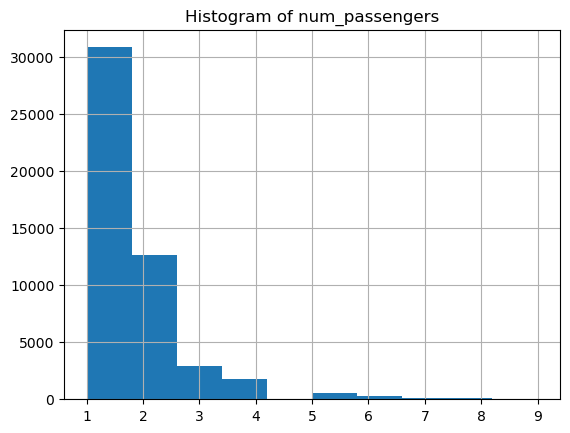

In [14]:
# Plot histogram of num_passengers.
df.num_passengers.hist()
plt.title('Histogram of num_passengers')
plt.show()

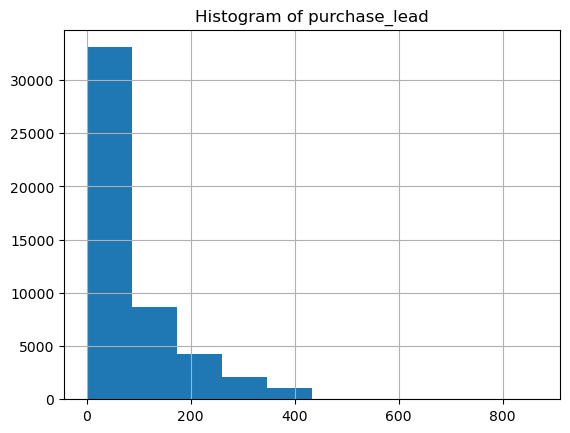

In [15]:
# Plot histogram of purchase_lead.
df.purchase_lead.hist()
plt.title('Histogram of purchase_lead')
plt.show()

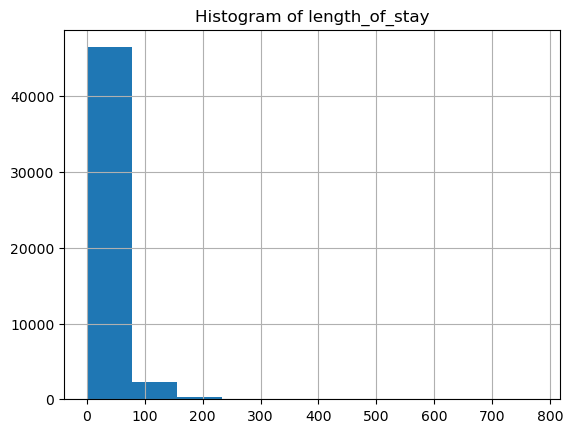

In [16]:
# Plot histogram of length_of_stay.
df.length_of_stay.hist()
plt.title('Histogram of length_of_stay')
plt.show()

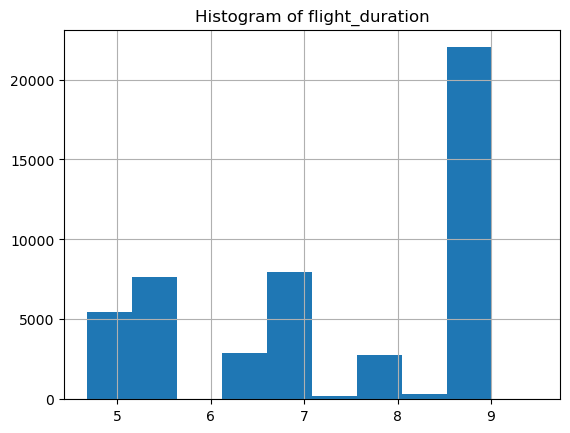

In [17]:
# Plot histogram of flight_duration.
df.flight_duration.hist()
plt.title('Histogram of flight_duration')
plt.show()

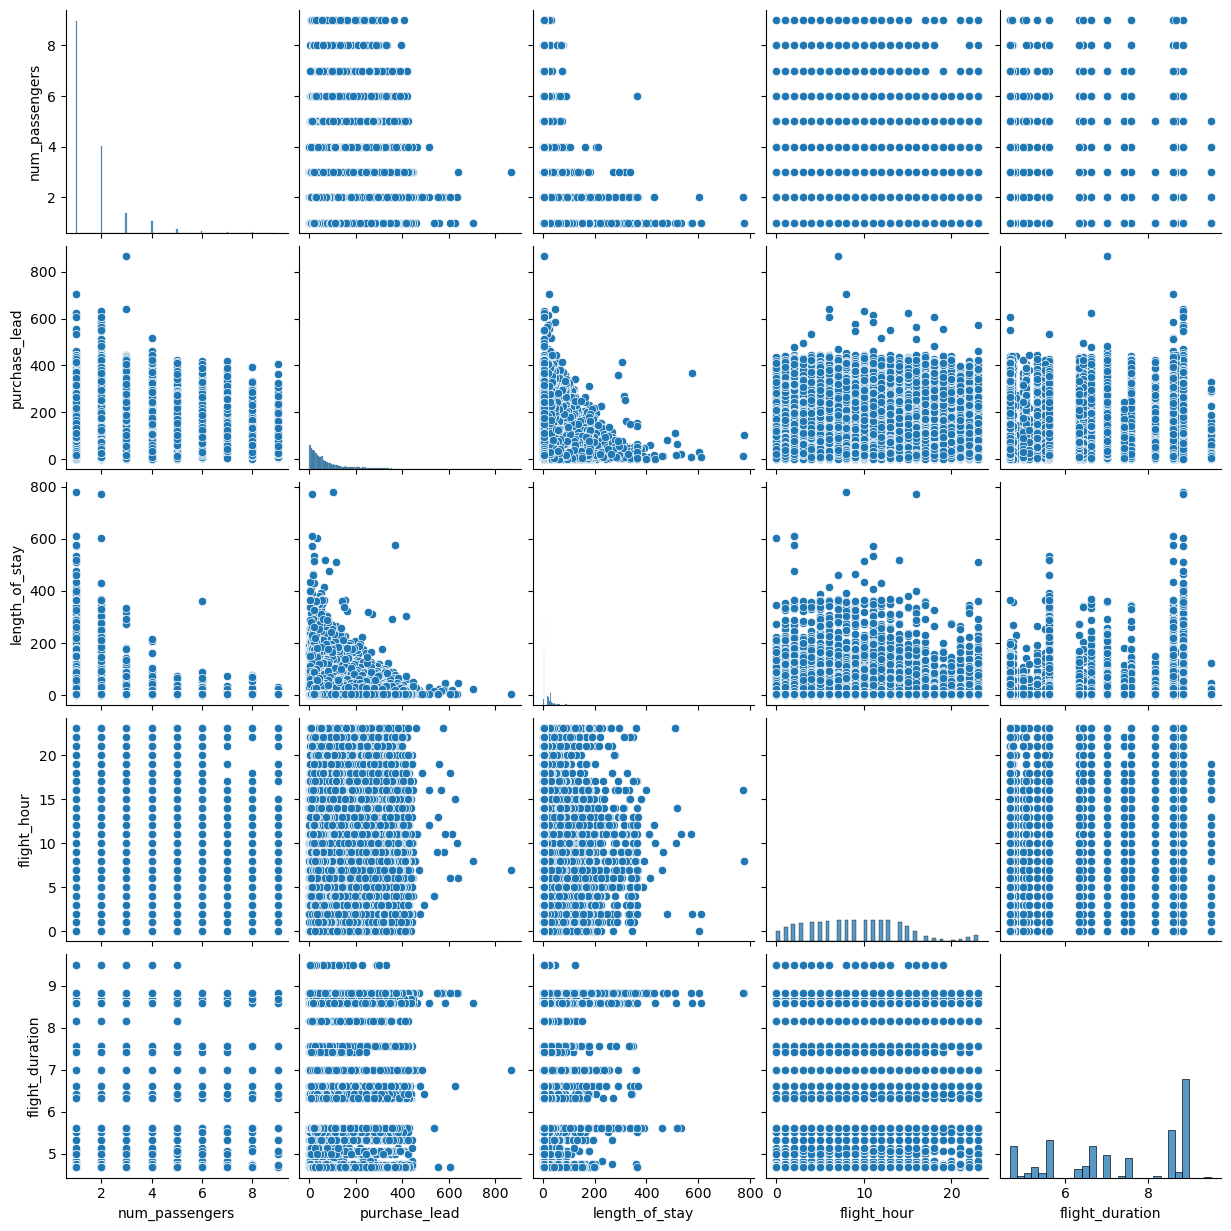

In [18]:
# Study of relationships between variables.
sns.pairplot(df[num_col])
plt.show()

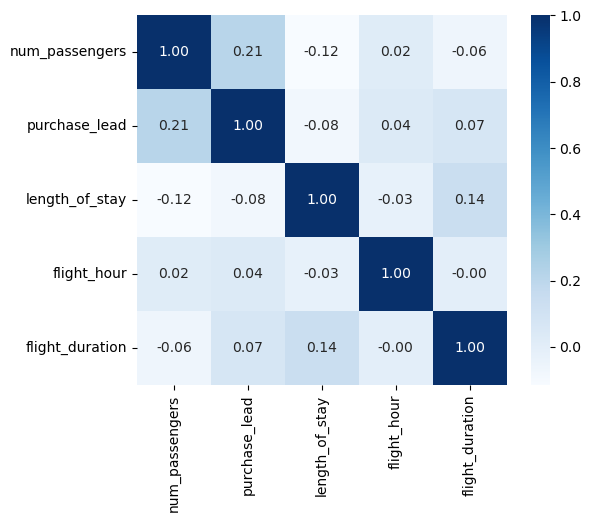

In [19]:
# Create heat map of the numerical veriables.
corr_df = df[num_col].corr()

sns.heatmap(corr_df,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 10},
            cmap="Blues")

plt.show()

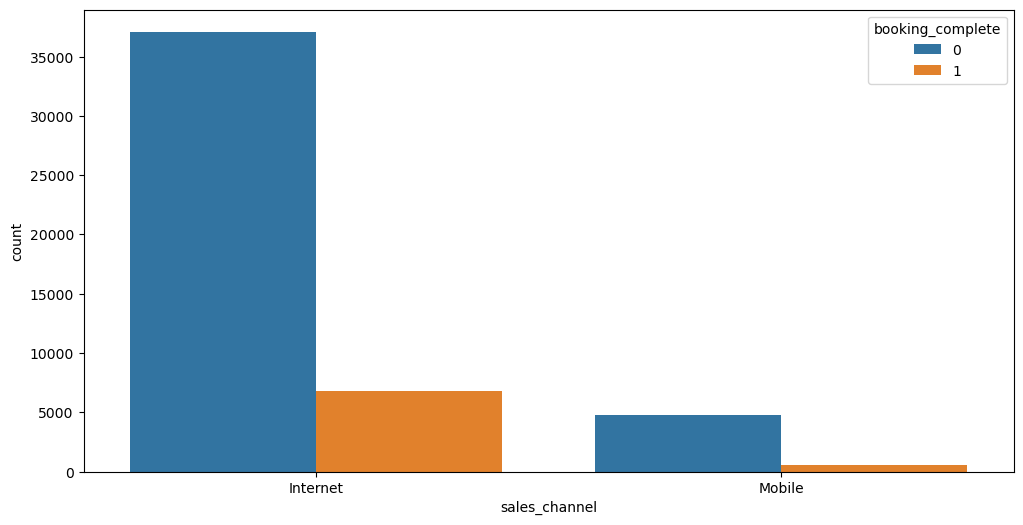

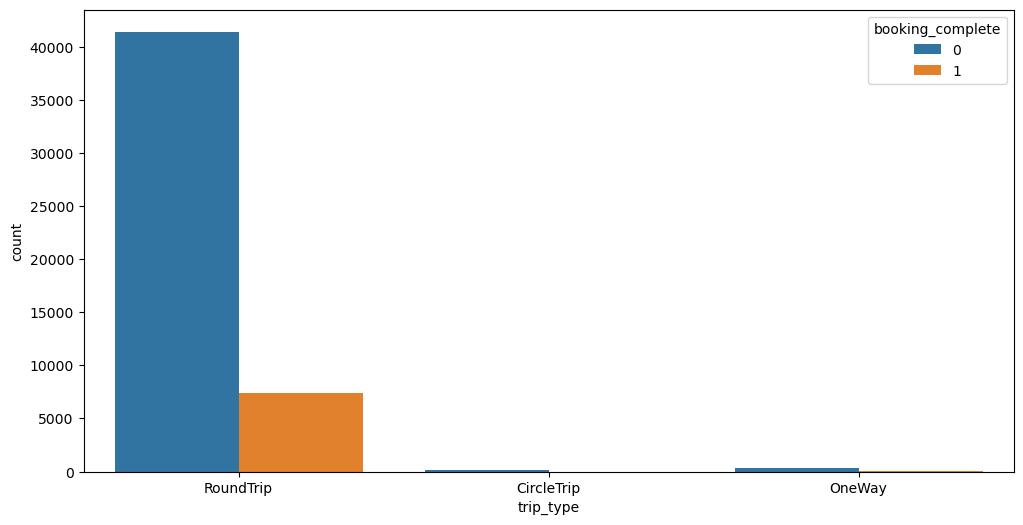

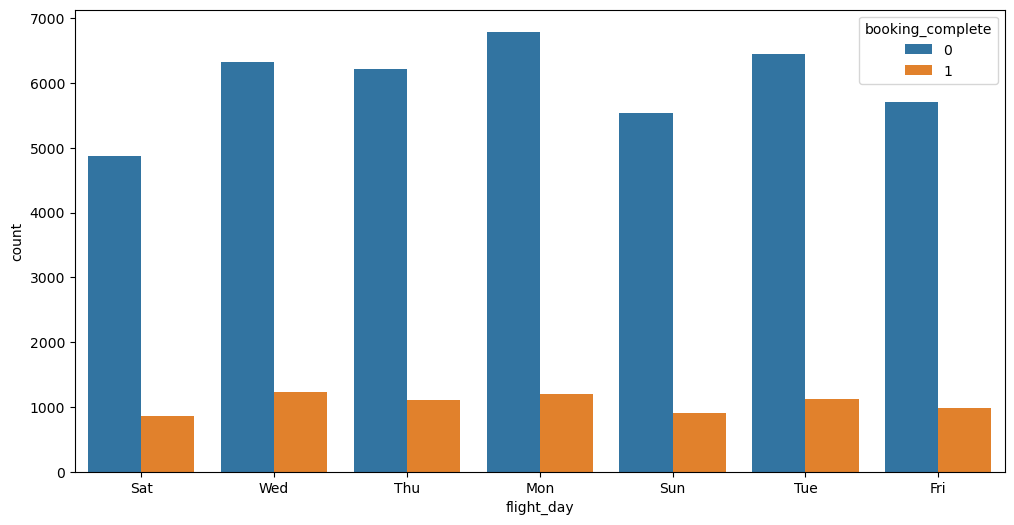

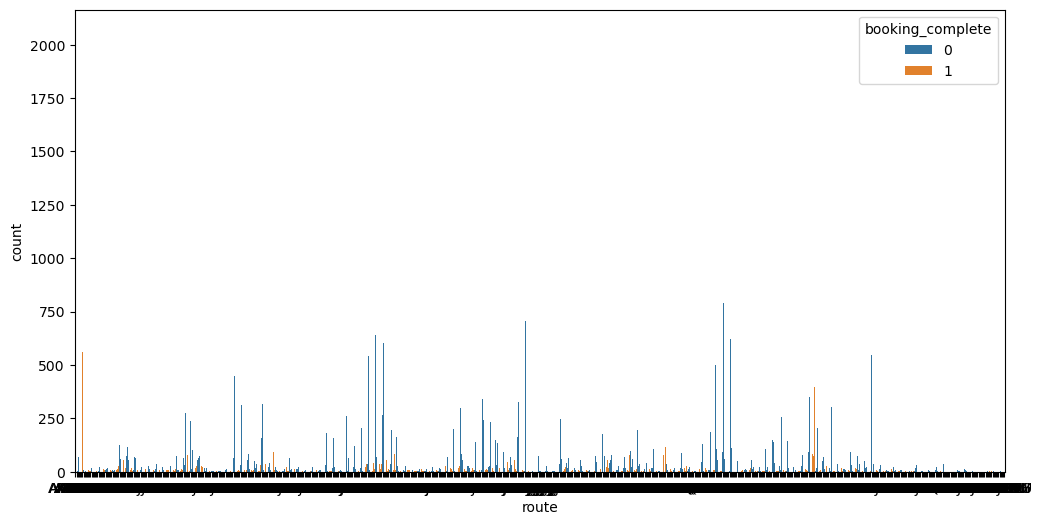

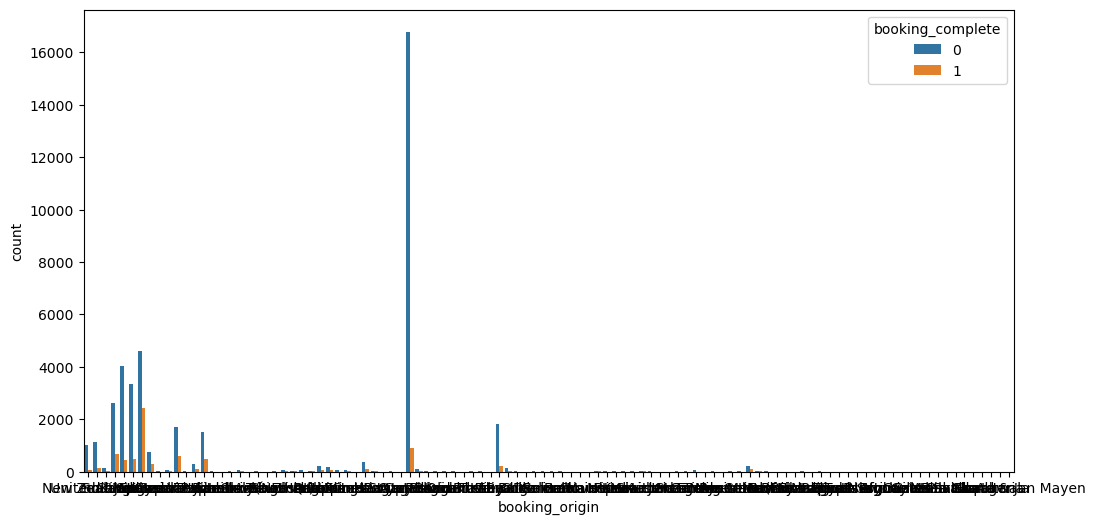

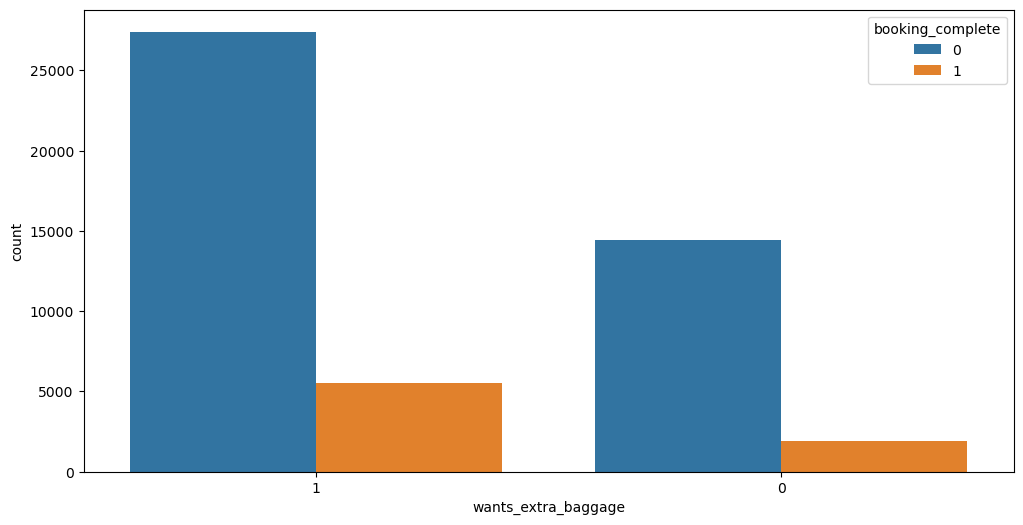

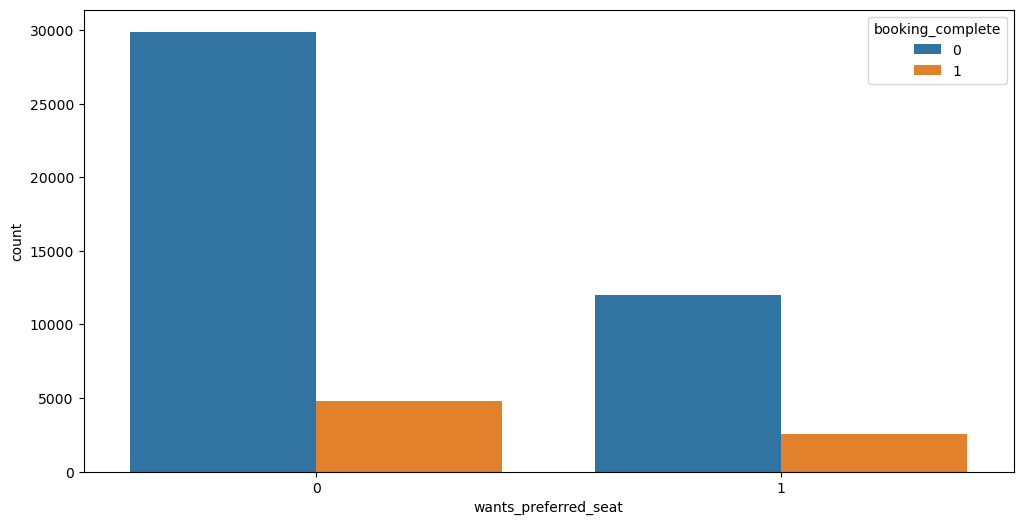

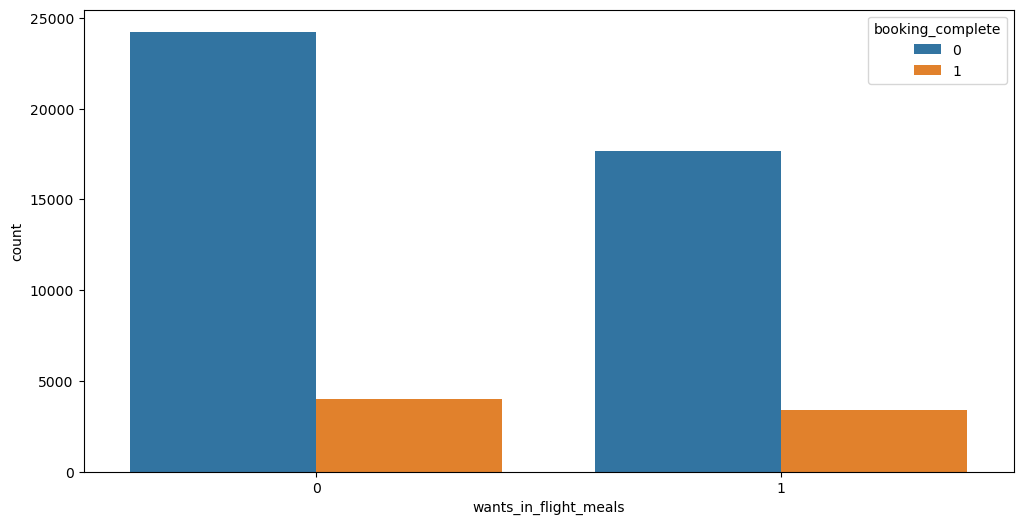

In [20]:
# Loop to plot the count of all the non numerical columns.
for column in obj_col[:-1]:
    plt.subplots(figsize=(12, 6))
    sns.countplot(data=df, x=column, hue='booking_complete')
    plt.show()

### Outliers Manual Removal

In [21]:
# Create function to import and process df.

def process_data(link):

    # Import the data.
    df = pd.read_csv(link, encoding="ISO-8859-1")

    # Remove duplicated rows in df.
    df.drop_duplicates(inplace=True, ignore_index=True)

    return df

In [22]:
# Import and process the data.
data_link = 'data/Project_Notes_010_BA_customer_booking.csv'
df = process_data(data_link)

In [23]:
# Check statistics of df.
df[num_col].describe().round(2)

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration
count,49281.00,49281.00,49281.00,49281.00,49281.00
mean,1.59,84.72,23.05,9.07,7.28
std,1.02,90.41,33.83,5.41,1.50
min,1.00,0.00,0.00,0.00,4.67
25%,1.00,21.00,5.00,5.00,5.62
50%,1.00,51.00,17.00,9.00,7.57
75%,2.00,115.00,28.00,13.00,8.83
max,9.00,867.00,778.00,23.00,9.50


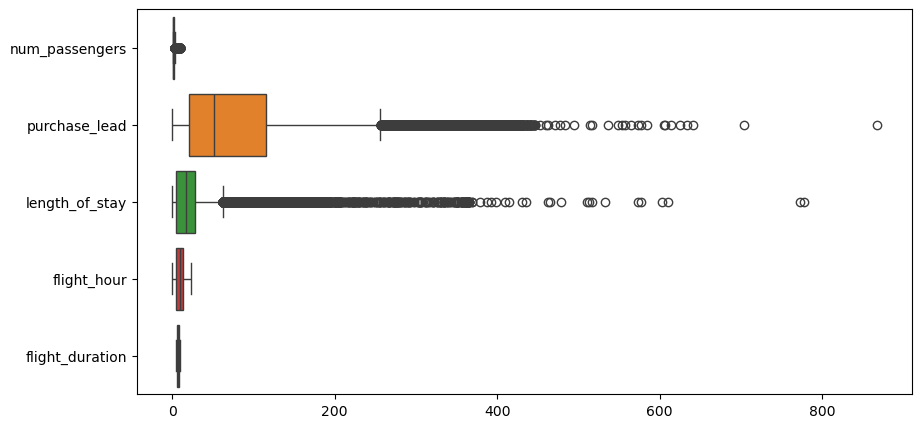

In [24]:
# Draw the boxplot to detect outliners.
plt.figure(figsize = (10,5))
sns.boxplot(data=df[num_col], orient="h")
plt.show()

In [25]:
# Calculate IQR and the limits.
Q1, Q3 = df[num_col].quantile(0.25), df[num_col].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

print(f'lower limits:\n{lower}\n')
print(f'upper limits:\n{upper}')

lower limits:
num_passengers      -0.500
purchase_lead     -120.000
length_of_stay     -29.500
flight_hour         -7.000
flight_duration      0.805
dtype: float64

upper limits:
num_passengers       3.500
purchase_lead      256.000
length_of_stay      62.500
flight_hour         25.000
flight_duration     13.645
dtype: float64


In [26]:
# Create function to remove outliers.
def out_remove(df):
    for col in num_col:
        out_remove = [False if x < lower[col] or x > upper[col] else True for x in df[col]]
        df = df[out_remove]
    return df

In [27]:
# Remove outliers in the 'num_col' columns.
df = out_remove(df)

In [28]:
# find length of df.
df_remain_length = df.shape[0]
print(f'df_remain_length: {df_remain_length}')

df_remain_length: 39902


In [29]:
# Find percentage of removed data.
removed_data = (df_original_length - df_remain_length) * 100 / df_original_length
print(f'removed_data: {round(removed_data, 2)}%')

removed_data: 19.03%


In [30]:
# Check statistics of df.
df[num_col].describe().round(2)

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration
count,39902.00,39902.00,39902.00,39902.00,39902.00
mean,1.39,66.40,16.22,9.07,7.25
std,0.60,61.94,14.28,5.39,1.50
min,1.00,0.00,0.00,0.00,4.67
25%,1.00,20.00,5.00,5.00,5.62
50%,1.00,46.00,6.00,9.00,7.57
75%,2.00,94.00,25.00,13.00,8.83
max,3.00,256.00,62.00,23.00,9.50


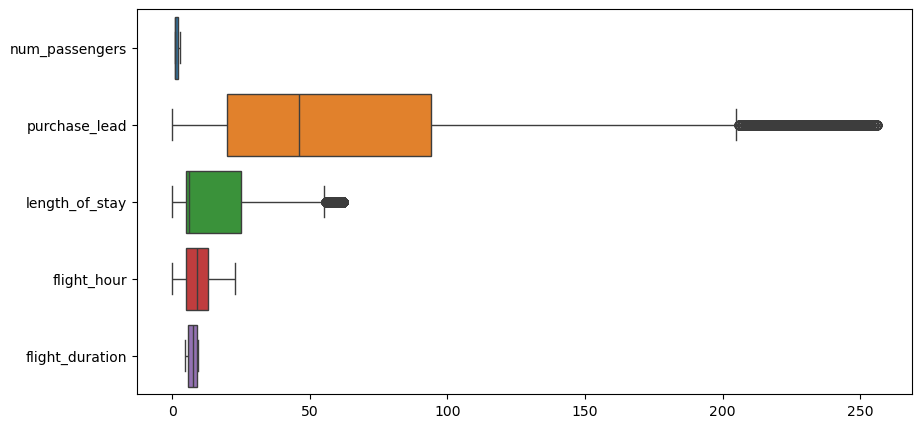

In [31]:
# Draw the boxplot to detect outliners.
plt.figure(figsize = (10,5))
sns.boxplot( data=df[num_col], orient="h")
plt.show()

In [32]:
# Function to count the values of a feature.
def val_counts(df):
    for col in df.columns:
        print(df[col].value_counts(),"\n\n")

In [33]:
# Inspect the value counts of df_obj.
val_counts(df[obj_col])

sales_channel
Internet    35376
Mobile       4526
Name: count, dtype: int64 


trip_type
RoundTrip     39493
OneWay          320
CircleTrip       89
Name: count, dtype: int64 


flight_day
Mon    6321
Wed    6269
Tue    6150
Thu    6068
Fri    5566
Sun    4899
Sat    4629
Name: count, dtype: int64 


route
AKLKUL    1810
PENTPE     782
ICNSIN     707
MELSGN     702
DMKPER     592
          ... 
JEDPEN       1
JOGKTM       1
KIXKTM       1
KNOKTM       1
MRUXIY       1
Name: count, Length: 784, dtype: int64 


booking_origin
Australia               14821
Malaysia                 5273
South Korea              3692
Japan                    3307
China                    2666
                        ...  
Slovakia                    1
Tanzania                    1
Jordan                      1
Lebanon                     1
Svalbard & Jan Mayen        1
Name: count, Length: 101, dtype: int64 


wants_extra_baggage
1    25793
0    14109
Name: count, dtype: int64 


wants_preferred_seat
0    2

In [34]:
# Take a closer look at the 'route' column value counts.
route_vc = df.route.value_counts()

# Re-distribute the 'purchase_lead' column values.
RUTE01 = route_vc[533:].index.to_list()
RUTE02 = route_vc[447:533].index.to_list()
RUTE03 = route_vc[392:447].index.to_list()
RUTE04 = route_vc[350:392].index.to_list()
RUTE05 = route_vc[315:350].index.to_list()
RUTE06 = route_vc[286:315].index.to_list()
RUTE07 = route_vc[260:286].index.to_list()
RUTE08 = route_vc[238:260].index.to_list()
RUTE09 = route_vc[218:238].index.to_list()
RUTE10 = route_vc[200:218].index.to_list()
RUTE11 = route_vc[185:200].index.to_list()
RUTE12 = route_vc[172:185].index.to_list()
RUTE13 = route_vc[160:172].index.to_list()
RUTE14 = route_vc[149:160].index.to_list()
RUTE15 = route_vc[138:149].index.to_list()
RUTE16 = route_vc[128:138].index.to_list()
RUTE17 = route_vc[119:128].index.to_list()
RUTE18 = route_vc[111:119].index.to_list()
RUTE19 = route_vc[103:111].index.to_list()
RUTE20 = route_vc[96:103].index.to_list()
RUTE21 = route_vc[89:96].index.to_list()
RUTE22 = route_vc[83:89].index.to_list()
RUTE23 = route_vc[77:83].index.to_list()
RUTE24 = route_vc[72:77].index.to_list()
RUTE25 = route_vc[67:72].index.to_list()
RUTE26 = route_vc[62:67].index.to_list()
RUTE27 = route_vc[58:62].index.to_list()
RUTE28 = route_vc[54:58].index.to_list()
RUTE29 = route_vc[50:54].index.to_list()
RUTE30 = route_vc[47:50].index.to_list()
RUTE31 = route_vc[47:50].index.to_list()
RUTE32 = route_vc[44:47].index.to_list()
RUTE33 = route_vc[41:44].index.to_list()
RUTE34 = route_vc[38:41].index.to_list()
RUTE35 = route_vc[35:38].index.to_list()
RUTE36 = route_vc[32:35].index.to_list()
RUTE37 = route_vc[30:32].index.to_list()
RUTE38 = route_vc[28:30].index.to_list()
RUTE39 = route_vc[26:28].index.to_list()
RUTE40 = route_vc[24:26].index.to_list()
RUTE41 = route_vc[22:24].index.to_list()
RUTE42 = route_vc[20:22].index.to_list()

In [35]:
# Create a function to re-distribute the 'route' column.

def distribute_route(df):
    
    df['route'].replace(RUTE01, 'RUTE01', inplace=True)
    df['route'].replace(RUTE02, 'RUTE02', inplace=True)
    df['route'].replace(RUTE03, 'RUTE03', inplace=True)
    df['route'].replace(RUTE04, 'RUTE04', inplace=True)
    df['route'].replace(RUTE05, 'RUTE05', inplace=True)
    df['route'].replace(RUTE06, 'RUTE06', inplace=True)
    df['route'].replace(RUTE07, 'RUTE07', inplace=True)
    df['route'].replace(RUTE08, 'RUTE08', inplace=True)
    df['route'].replace(RUTE09, 'RUTE09', inplace=True)
    df['route'].replace(RUTE10, 'RUTE10', inplace=True)
    df['route'].replace(RUTE11, 'RUTE11', inplace=True)
    df['route'].replace(RUTE12, 'RUTE12', inplace=True)
    df['route'].replace(RUTE13, 'RUTE13', inplace=True)
    df['route'].replace(RUTE14, 'RUTE14', inplace=True)
    df['route'].replace(RUTE15, 'RUTE15', inplace=True)
    df['route'].replace(RUTE16, 'RUTE16', inplace=True)
    df['route'].replace(RUTE17, 'RUTE17', inplace=True)
    df['route'].replace(RUTE18, 'RUTE18', inplace=True)
    df['route'].replace(RUTE19, 'RUTE19', inplace=True)
    df['route'].replace(RUTE20, 'RUTE20', inplace=True)
    df['route'].replace(RUTE21, 'RUTE21', inplace=True)
    df['route'].replace(RUTE22, 'RUTE22', inplace=True)
    df['route'].replace(RUTE23, 'RUTE23', inplace=True)
    df['route'].replace(RUTE24, 'RUTE24', inplace=True)
    df['route'].replace(RUTE25, 'RUTE25', inplace=True)
    df['route'].replace(RUTE26, 'RUTE26', inplace=True)
    df['route'].replace(RUTE27, 'RUTE27', inplace=True)
    df['route'].replace(RUTE28, 'RUTE28', inplace=True)
    df['route'].replace(RUTE29, 'RUTE29', inplace=True)
    df['route'].replace(RUTE30, 'RUTE30', inplace=True)
    df['route'].replace(RUTE31, 'RUTE31', inplace=True)
    df['route'].replace(RUTE32, 'RUTE32', inplace=True)
    df['route'].replace(RUTE33, 'RUTE33', inplace=True)
    df['route'].replace(RUTE34, 'RUTE34', inplace=True)
    df['route'].replace(RUTE35, 'RUTE35', inplace=True)
    df['route'].replace(RUTE36, 'RUTE36', inplace=True)
    df['route'].replace(RUTE37, 'RUTE37', inplace=True)
    df['route'].replace(RUTE38, 'RUTE38', inplace=True)
    df['route'].replace(RUTE39, 'RUTE39', inplace=True)
    df['route'].replace(RUTE40, 'RUTE40', inplace=True)
    df['route'].replace(RUTE41, 'RUTE41', inplace=True)
    df['route'].replace(RUTE42, 'RUTE42', inplace=True)

    return df

In [36]:
# Re-distribute the 'route' column.
df = distribute_route(df)

In [37]:
# Check the value counts of the 'route' column.
df.route.value_counts()

route
AKLKUL    1810
RUTE36     795
PENTPE     782
RUTE29     769
RUTE10     766
          ... 
HNDPEN     358
COKMEL     353
PENPER     333
DPSPVG     319
HKTSYD     313
Name: count, Length: 61, dtype: int64

In [38]:
# Define the country groups.
Africa = ['South Africa', 'Kenya', 'Tunisia', 'Ghana', 'Seychelles', 'Algeria', 'Egypt', 'Tanzania', 'Mauritius', 'Réunion']

North_America = ['United States', 'Canada', 'Mexico', 'Guatemala', 'Nicaragua', 'Panama']

South_America = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Paraguay', 'Peru']

East_Asia = ['China', 'Hong Kong', 'Japan', 'Macau', 'Mongolia', 'South Korea', 'Taiwan', 'Kazakhstan']

South_Asia = ['Bangladesh', 'Bhutan', 'India', 'Pakistan', 'Nepal', 'Sri Lanka', 'Afghanistan', 'Maldives']

Southeast_Asia = ['Brunei', 'Cambodia', 'Timor-Leste', 'Indonesia', 'Laos', 
                 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam', 'Myanmar (Burma)']

Europe = ['Svalbard & Jan Mayen', 'United Kingdom', 'France', 'Germany', 'Italy', 'Netherlands', 'Russia', 'Spain', 'Switzerland', 
         'Turkey', 'Poland', 'Czech Republic', 'Austria', 'Greece', 'Belgium', 'Ireland', 'Portugal', 'Ukraine', 'Romania', 'Croatia', 
         'Hungary', 'Israel', 'Slovenia', 'Cyprus', 'Czechia', 'Malta', 'Gibraltar', 'Belarus', 'Estonia', 'Slovakia', 'Bulgaria']

Middle_East = ['United Arab Emirates', 'Saudi Arabia', 'Qatar', 'Iran', 'Oman', 'Kuwait', 'Bahrain', 'Iraq', 'Lebanon', 'Jordan']

Nordic = ['Denmark', 'Norway', 'Sweden', 'Finland']

Oceania = ['Australia', 'New Zealand', 'Vanuatu', 'Tonga', 'Papua New Guinea', 'Norfolk Island', 'New Caledonia', 'Solomon Islands', 'Guam']

Unknown = ['(not set)']

In [39]:
# Create a function to group the 'booking_origin' column.

def group_booking(df):
    
    df['booking_origin'].replace(Africa, 'Africa', inplace=True)
    df['booking_origin'].replace(North_America, 'North_America', inplace=True)
    df['booking_origin'].replace(South_America, 'South_America', inplace=True)
    df['booking_origin'].replace(East_Asia, 'East_Asia', inplace=True)
    df['booking_origin'].replace(South_Asia, 'South_Asia', inplace=True)
    df['booking_origin'].replace(Southeast_Asia, 'Southeast_Asia', inplace=True)
    df['booking_origin'].replace(Europe, 'Europe', inplace=True)
    df['booking_origin'].replace(Middle_East, 'Middle_East', inplace=True)
    df['booking_origin'].replace(Nordic, 'Nordic', inplace=True)
    df['booking_origin'].replace(Oceania, 'Oceania', inplace=True)
    df['booking_origin'].replace(Unknown, 'Unknown', inplace=True)

    return df

In [40]:
# Re-group the 'booking_origin' column.
df = group_booking(df)

In [41]:
# Check the value counts of the 'booking_origin' column.
df.booking_origin.value_counts()

booking_origin
Oceania           15589
East_Asia         11938
Southeast_Asia    10044
South_Asia         1099
Europe              478
North_America       464
Middle_East         110
Unknown              66
Africa               55
South_America        33
Nordic               26
Name: count, dtype: int64

In [42]:
# Split dataset to train, test and validation sets.
y = df['booking_complete']
X = df.drop('booking_complete', axis=1)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [43]:
# Create the preprocessor.
numeric_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 
                        'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

preprocessor = make_column_transformer(
                                        (StandardScaler(), numeric_features),
                                        (OrdinalEncoder(), categorical_features)
                                       )

In [44]:
# Train a xgb classifier model.
xgb = make_pipeline(preprocessor, XGBClassifier())
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [45]:
# Compute f1_score and confusion_matrix.
pred_val = xgb.predict(X_val)

f1_val = f1_score(y_val, pred_val, average='micro')
confusion_val = confusion_matrix(y_val, pred_val)

print(f'f1_val: {f1_val.round(4)}\n')
print(f'confusion_val:\n{confusion_val.round(4)}')

f1_val: 0.8435

confusion_val:
[[6591  208]
 [1041  141]]


In [46]:
# Use GridSearchCV to find the best hyperparameters.

xgb = make_pipeline(preprocessor, XGBClassifier())

params = {
            'xgbclassifier__eta': [0.1, 0.2, 0.3],
            'xgbclassifier__max_depth': [2, 5, 10],
            'xgbclassifier__min_child_weight': [3, 10, 20]
         }

gscv = GridSearchCV(
                    estimator=xgb,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1
                    )

gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['num_passengers',
                                                                          'purchase_lead',
                                                                          'length_of_stay',
                                                                          'flight_hour',
                                                                          'flight_duration']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['sales_channel',
                                                                          'trip_type',
                                                                          'flight_day',
                                                                          'route',
                                                                          'booking_origin',
                                                                          'wants_extra_baggage',
                                                                          'wants_pr...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__eta': [0.1, 0.2, 0.3],
                         'xgbclassifier__max_depth': [2, 5, 10],
                         'xgbclassifier__min_child_weight': [3, 10, 20]})

In [47]:
# Get model best parameters.
best_params = gscv.best_params_
print(f'best_params:\n{best_params}')

best_params:
{'xgbclassifier__eta': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 10}


In [48]:
# Extract the parameters.
eta = best_params['xgbclassifier__eta']
max_depth = best_params['xgbclassifier__max_depth']
min_child_weight = best_params['xgbclassifier__min_child_weight']

print(f'eta: {eta}')
print(f'max_depth: {max_depth}')
print(f'min_child_weight: {min_child_weight}')

eta: 0.1
max_depth: 2
min_child_weight: 10


In [49]:
# Train with full_train.
final_model = make_pipeline(preprocessor, XGBClassifier(eta=eta, max_depth=max_depth, min_child_weight=min_child_weight))
final_model.fit(X_full_train, y_full_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [50]:
# Compute f1_score and confusion_matrix.
pred_test = final_model.predict(X_test)

f1_test = f1_score(y_test, pred_test, average='micro')
confusion_test = confusion_matrix(y_test, pred_test)

print(f'f1_test: {f1_test.round(4)}\n')
print(f'confusion_test:\n{confusion_test.round(4)}')

f1_test: 0.8535

confusion_test:
[[6794   10]
 [1159   18]]


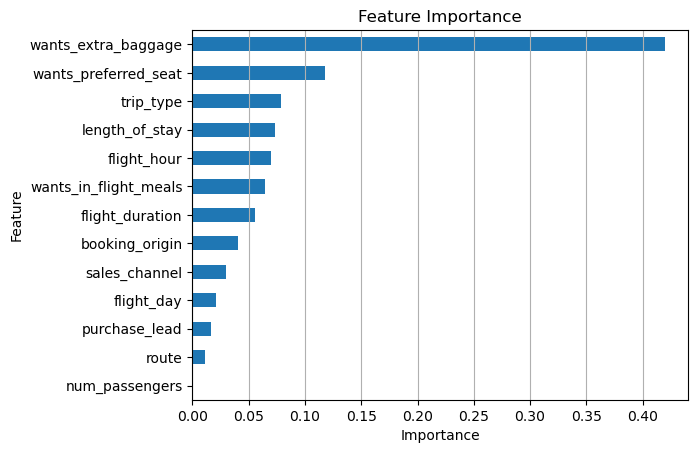

In [51]:
# Get feature names from training data.
features = X_full_train.columns

# Extract importances from model.
importances = final_model.named_steps["xgbclassifier"].feature_importances_

# Create a series with feature names and importances.
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features.
feat_imp.tail(13).plot(kind="barh", xlabel="Importance", ylabel="Feature", title="Feature Importance")
plt.grid(visible=True, axis='x',)
plt.show()

### Outliers replacement with boundries

In [52]:
# Import and process the data.
data_link = 'data/Project_Notes_010_BA_customer_booking.csv'
df = process_data(data_link)

In [53]:
# Create function to replace outliers with the boundries.
def out_boundry(df):
    for col in num_col:
        lower_index = [x for x in range(len(df[col])) if df[col][x] < lower[col]]
        df.loc[lower_index, col] = lower[col]
        upper_index = [x for x in range(len(df[col])) if df[col][x] > upper[col]]
        df.loc[upper_index, col] = upper[col]
    return df

In [54]:
# Replace outliers in the 'IQR_col' columns.
df = out_boundry(df)

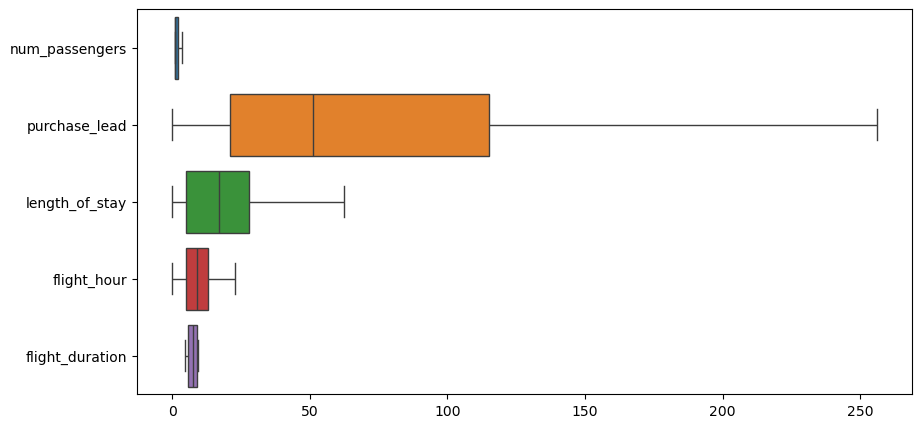

In [55]:
# Draw the boxplot to detect outliners.
plt.figure(figsize = (10,5))
sns.boxplot( data=df[num_col], orient="h")
plt.show()

In [56]:
# Re-distribute the 'route' column.
df = distribute_route(df)

In [57]:
# Re-group the 'booking_origin' column.
df = group_booking(df)

In [58]:
# Split dataset to train, test and validation sets.
y = df['booking_complete']
X = df.drop('booking_complete', axis=1)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [59]:
# Create the preprocessor.
numeric_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 
                        'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

preprocessor = make_column_transformer(
                                        (StandardScaler(), numeric_features),
                                        (OrdinalEncoder(), categorical_features)
                                       )

In [60]:
# Train a xgb classifier model.
xgb = make_pipeline(preprocessor, XGBClassifier())
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [61]:
# Compute f1_score and confusion_matrix.
pred_val = xgb.predict(X_val)

f1_val = f1_score(y_val, pred_val, average='micro')
confusion_val = confusion_matrix(y_val, pred_val)

print(f'f1_val: {f1_val.round(4)}\n')
print(f'confusion_val:\n{confusion_val.round(4)}')

f1_val: 0.8388

confusion_val:
[[8089  214]
 [1375  178]]


In [62]:
# Use GridSearchCV to find the best hyperparameters.

xgb = make_pipeline(preprocessor, XGBClassifier())

params = {
            'xgbclassifier__eta': [0.1, 0.2, 0.3],
            'xgbclassifier__max_depth': [2, 5, 10],
            'xgbclassifier__min_child_weight': [10, 20, 30]
         }

gscv = GridSearchCV(
                    estimator=xgb,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1
                    )

gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['num_passengers',
                                                                          'purchase_lead',
                                                                          'length_of_stay',
                                                                          'flight_hour',
                                                                          'flight_duration']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['sales_channel',
                                                                          'trip_type',
                                                                          'flight_day',
                                                                          'route',
                                                                          'booking_origin',
                                                                          'wants_extra_baggage',
                                                                          'wants_pr...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__eta': [0.1, 0.2, 0.3],
                         'xgbclassifier__max_depth': [2, 5, 10],
                         'xgbclassifier__min_child_weight': [10, 20, 30]})

In [63]:
# Get model best parameters.
best_params = gscv.best_params_
print(f'best_params:\n{best_params}')

best_params:
{'xgbclassifier__eta': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 10}


In [64]:
# Extract the parameters.
eta = best_params['xgbclassifier__eta']
max_depth = best_params['xgbclassifier__max_depth']
min_child_weight = best_params['xgbclassifier__min_child_weight']

print(f'eta: {eta}')
print(f'max_depth: {max_depth}')
print(f'min_child_weight: {min_child_weight}')

eta: 0.1
max_depth: 5
min_child_weight: 10


In [65]:
# Train with full_train.
final_model = make_pipeline(preprocessor, XGBClassifier(eta=eta, max_depth=max_depth, min_child_weight=min_child_weight))
final_model.fit(X_full_train, y_full_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [66]:
# Compute f1_score and confusion_matrix.
pred_test = final_model.predict(X_test)

f1_test = f1_score(y_test, pred_test, average='micro')
confusion_test = confusion_matrix(y_test, pred_test)

print(f'f1_test: {f1_test.round(4)}\n')
print(f'confusion_test:\n{confusion_test.round(4)}')

f1_test: 0.8509

confusion_test:
[[8322   55]
 [1415   65]]


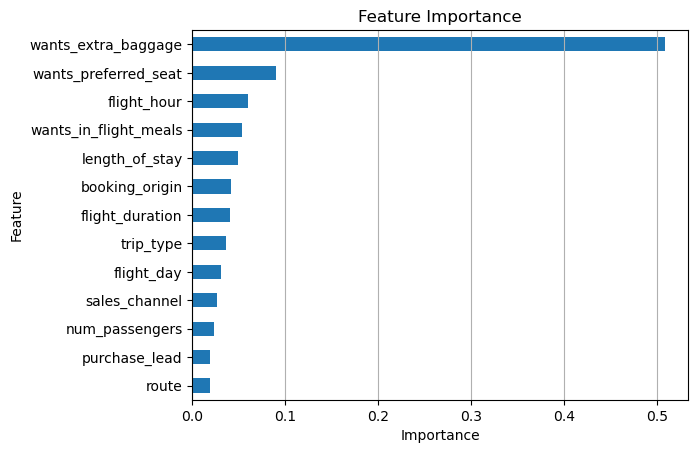

In [67]:
# Get feature names from training data.
features = X_full_train.columns

# Extract importances from model.
importances = final_model.named_steps["xgbclassifier"].feature_importances_

# Create a series with feature names and importances.
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features.
feat_imp.tail(13).plot(kind="barh", xlabel="Importance", ylabel="Feature", title="Feature Importance")
plt.grid(visible=True, axis='x',)
plt.show()

### Outliers replacement with median

In [68]:
# Import and process the data.
data_link = "data/Project_Notes_010_BA_customer_booking.csv"
df = process_data(data_link)

In [69]:
# Calculate the median of the IQR_col.
middle = df[num_col].median()
print(middle)

num_passengers      1.00
purchase_lead      51.00
length_of_stay     17.00
flight_hour         9.00
flight_duration     7.57
dtype: float64


In [70]:
# Create function to replace outliers with the median.
def out_median(df):
    for col in num_col:
        lower_index = [x for x in range(len(df[col])) if df[col][x] < lower[col]]
        df.loc[lower_index, col] = middle[col]
        upper_index = [x for x in range(len(df[col])) if df[col][x] > upper[col]]
        df.loc[upper_index, col] = middle[col]
    return df

In [71]:
# Replace outliers in the 'IQR_col' columns.
df = out_median(df)

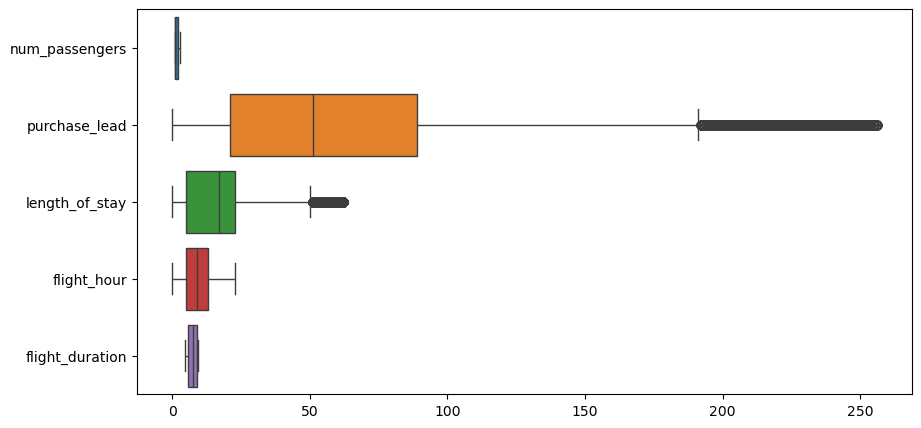

In [72]:
# Draw the boxplot to detect outliners.
plt.figure(figsize = (10,5))
sns.boxplot( data=df[num_col], orient="h")
plt.show()

In [73]:
# Re-distribute the 'route' column.
df = distribute_route(df)

In [74]:
# Re-group the 'booking_origin' column.
df = group_booking(df)

In [75]:
# Split dataset to train, test and validation sets.
y = df['booking_complete']
X = df.drop('booking_complete', axis=1)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [76]:
# Create the preprocessor.
numeric_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 
                        'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

preprocessor = make_column_transformer(
                                        (StandardScaler(), numeric_features),
                                        (OrdinalEncoder(), categorical_features)
                                       )

In [77]:
# Train a xgb classifier model.
xgb = make_pipeline(preprocessor, XGBClassifier())
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [78]:
# Compute f1_score and confusion_matrix.
pred_val = xgb.predict(X_val)

f1_val = f1_score(y_val, pred_val, average='micro')
confusion_val = confusion_matrix(y_val, pred_val)

print(f'f1_val: {f1_val.round(4)}\n')
print(f'confusion_val:\n{confusion_val.round(4)}')

f1_val: 0.8364

confusion_val:
[[8079  224]
 [1388  165]]


In [79]:
# Use GridSearchCV to find the best hyperparameters.

xgb = make_pipeline(preprocessor, XGBClassifier())

params = {
            'xgbclassifier__eta': [0.1, 0.2, 0.3],
            'xgbclassifier__max_depth': [2, 5, 10],
            'xgbclassifier__min_child_weight': [10, 20, 30]
         }

gscv = GridSearchCV(
                    estimator=xgb,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1
                    )

gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['num_passengers',
                                                                          'purchase_lead',
                                                                          'length_of_stay',
                                                                          'flight_hour',
                                                                          'flight_duration']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['sales_channel',
                                                                          'trip_type',
                                                                          'flight_day',
                                                                          'route',
                                                                          'booking_origin',
                                                                          'wants_extra_baggage',
                                                                          'wants_pr...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__eta': [0.1, 0.2, 0.3],
                         'xgbclassifier__max_depth': [2, 5, 10],
                         'xgbclassifier__min_child_weight': [10, 20, 30]})

In [80]:
# Get model best parameters.
best_params = gscv.best_params_
print(f'best_params:\n{best_params}')

best_params:
{'xgbclassifier__eta': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 20}


In [81]:
# Extract the parameters.
eta = best_params['xgbclassifier__eta']
max_depth = best_params['xgbclassifier__max_depth']
min_child_weight = best_params['xgbclassifier__min_child_weight']

print(f'eta: {eta}')
print(f'max_depth: {max_depth}')
print(f'min_child_weight: {min_child_weight}')

eta: 0.1
max_depth: 2
min_child_weight: 20


In [82]:
# Train with full_train.
final_model = make_pipeline(preprocessor, XGBClassifier(eta=eta, max_depth=max_depth, min_child_weight=min_child_weight))
final_model.fit(X_full_train, y_full_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=20, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [83]:
# Compute f1_score and confusion_matrix.
pred_test = final_model.predict(X_test)

f1_test = f1_score(y_test, pred_test, average='micro')
confusion_test = confusion_matrix(y_test, pred_test)

print(f'f1_test: {f1_test.round(4)}\n')
print(f'confusion_test:\n{confusion_test.round(4)}')

f1_test: 0.8501

confusion_test:
[[8367   10]
 [1468   12]]


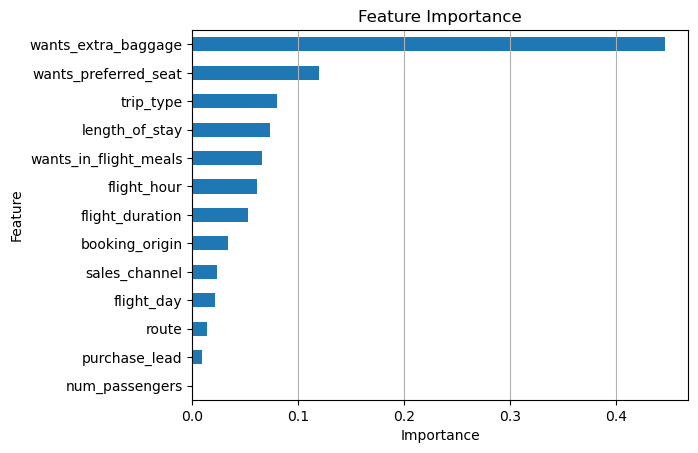

In [84]:
# Get feature names from training data.
features = X_full_train.columns

# Extract importances from model.
importances = final_model.named_steps["xgbclassifier"].feature_importances_

# Create a series with feature names and importances.
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features.
feat_imp.tail(13).plot(kind="barh", xlabel="Importance", ylabel="Feature", title="Feature Importance")
plt.grid(visible=True, axis='x',)
plt.show()

### Outliers removal with LocalOutlierFactor

In [85]:
# Import and process the data.
data_link = 'data/Project_Notes_010_BA_customer_booking.csv'
df = process_data(data_link)

In [86]:
# Identify outliers in the training dataset.
lof = LocalOutlierFactor()
hat_lof = lof.fit_predict(df[num_col])

In [87]:
# Select all rows that are not outliers.
mask_lof = hat_lof != -1
df = df[mask_lof]

In [88]:
# Check statistics of df.
df[num_col].describe().round(2)

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration
count,48995.00,48995.00,48995.00,48995.00,48995.00
mean,1.57,84.45,22.83,9.06,7.28
std,0.96,89.72,32.06,5.40,1.50
min,1.00,0.00,0.00,0.00,4.67
25%,1.00,21.00,5.00,5.00,5.62
50%,1.00,51.00,17.00,9.00,7.57
75%,2.00,115.00,28.00,13.00,8.83
max,9.00,584.00,379.00,23.00,9.50


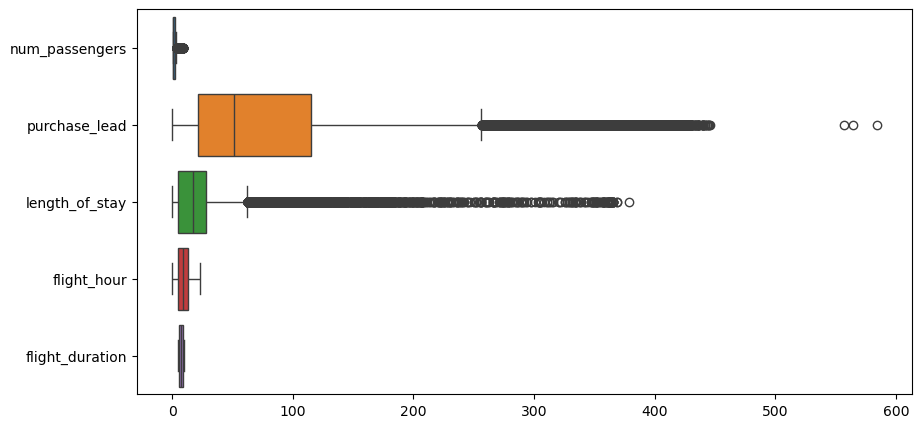

In [89]:
# Draw the boxplot to detect outliners.
plt.figure(figsize = (10,5))
sns.boxplot( data=df[num_col], orient="h")
plt.show()

In [90]:
# Re-distribute the 'route' column.
df = distribute_route(df)

In [91]:
# Re-group the 'booking_origin' column.
df = group_booking(df)

In [92]:
# Split dataset to train, test and validation sets.
y = df['booking_complete']
X = df.drop('booking_complete', axis=1)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [93]:
# Create the preprocessor.
numeric_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 
                        'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

preprocessor = make_column_transformer(
                                        (StandardScaler(), numeric_features),
                                        (OrdinalEncoder(), categorical_features)
                                       )

In [94]:
# Train a xgb classifier model.
xgb = make_pipeline(preprocessor, XGBClassifier())
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [95]:
# Compute f1_score and confusion_matrix.
pred_val = xgb.predict(X_val)

f1_val = f1_score(y_val, pred_val, average='micro')
confusion_val = confusion_matrix(y_val, pred_val)

print(f'f1_val: {f1_val.round(4)}\n')
print(f'confusion_val:\n{confusion_val.round(4)}')

f1_val: 0.8495

confusion_val:
[[8146  238]
 [1237  178]]


In [96]:
# Use GridSearchCV to find the best hyperparameters.

xgb = make_pipeline(preprocessor, XGBClassifier())

params = {
            'xgbclassifier__eta': [0.1, 0.2, 0.3],
            'xgbclassifier__max_depth': [2, 5, 10],
            'xgbclassifier__min_child_weight': [10, 20, 30]
         }

gscv = GridSearchCV(
                    estimator=xgb,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1
                    )

gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['num_passengers',
                                                                          'purchase_lead',
                                                                          'length_of_stay',
                                                                          'flight_hour',
                                                                          'flight_duration']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['sales_channel',
                                                                          'trip_type',
                                                                          'flight_day',
                                                                          'route',
                                                                          'booking_origin',
                                                                          'wants_extra_baggage',
                                                                          'wants_pr...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__eta': [0.1, 0.2, 0.3],
                         'xgbclassifier__max_depth': [2, 5, 10],
                         'xgbclassifier__min_child_weight': [10, 20, 30]})

In [97]:
# Get model best parameters.
best_params = gscv.best_params_
print(f'best_params:\n{best_params}')

best_params:
{'xgbclassifier__eta': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 30}


In [98]:
# Extract the parameters.
eta = best_params['xgbclassifier__eta']
max_depth = best_params['xgbclassifier__max_depth']
min_child_weight = best_params['xgbclassifier__min_child_weight']

print(f'eta: {eta}')
print(f'max_depth: {max_depth}')
print(f'min_child_weight: {min_child_weight}')

eta: 0.1
max_depth: 5
min_child_weight: 30


In [99]:
# Train with full_train.
final_model = make_pipeline(preprocessor, XGBClassifier(eta=eta, max_depth=max_depth, min_child_weight=min_child_weight))
final_model.fit(X_full_train, y_full_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flig...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=30, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [100]:
# Compute f1_score and confusion_matrix.
pred_test = final_model.predict(X_test)

f1_test = f1_score(y_test, pred_test, average='micro')
confusion_test = confusion_matrix(y_test, pred_test)

print(f'f1_test: {f1_test.round(4)}\n')
print(f'confusion_test:\n{confusion_test.round(4)}')

f1_test: 0.8526

confusion_test:
[[8284   67]
 [1377   71]]


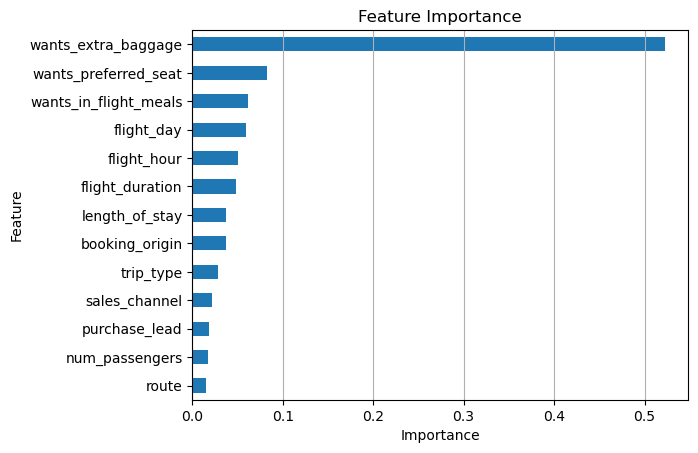

In [101]:
# Get feature names from training data.
features = X_full_train.columns

# Extract importances from model.
importances = final_model.named_steps["xgbclassifier"].feature_importances_

# Create a series with feature names and importances.
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features.
feat_imp.tail(13).plot(kind="barh", xlabel="Importance", ylabel="Feature", title="Feature Importance")
plt.grid(visible=True, axis='x',)
plt.show()

#### In conclusion f1_score for: 
#####    Outliers removal manually -> **0.8535**
#####    Outliers replacement with boundries -> **0.8509**
#####    Outliers replacement with median -> **0.8501**
#####    Outliers removal with LocalOutlierFactor -> **0.8526**